# Scope of the problem
***
Your boss asked you (a recently hired data scientist) to **build a model to predict the median princing of houses in a region of California**. You have data of districts within that region (600 to 3000 inhabitantas per district). The results of your model will be used in a subsequent model to analyze the opportunity for investing in such region. <br>

As of now, **this task is performed manually in a time- and cost-inefficient way**. No to mention that the average predictions have been producing errors of ~20%.

<font color ='blue'> >> </font> This looks like a **supervised, regression problem** (we are trying to predict a numeric varialbe `house prices`) and most likely we could apply a **batch learning** method. 

After understanding the problem, we need to select a metric to evaluate the performance of the models. One that is fairly commonly used in regression problems is the Root Mean Square Error (RMSE). The equantion bellow represents how RMSE is calculated.

$RMSE(\mathbf{X}, \mathit{h}) = \sqrt{\frac{1}{\mathit{m}}\sum_{i=1}^{m}(h(\mathbf{x}^{i}) -y^{i})^{2}}$ 

<font color ='blue'> >> </font> From here on now, I will have more contact with some of the math behind the models and metrics. In this sense, I decided to take a look into what each term mean.
* *m* is the numer of data entries you are measuring. So if your validation set has 299 rows, *m* = 299
* $\mathbf{x}^{i}\$ is a vector of all the features, except the label.

* $\mathbf{y}^{i}\$ is the label.

Just to make it clearer, lets say that the values for our first district were 123, 321, 2 and 25,000 for `number of houses`, `number of inhabitants`, `number of hospitals` and `average house pricing`, respectively. This would give us the following: <br>
$\mathbf{x}^{i} = \begin{pmatrix} 123\\ 321\\ 2\\ \end{pmatrix}$

$\mathbf{y}^{i}\ = 25,000$

* **X** 
 
<font coloR='red'> TO DO



# Download the data 

In [1]:
import os 
import tarfile
import urllib
import pandas as pd

In [2]:
download_root = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
housing_path = os.path.join("datasets", "housing")
housing_url = download_root + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=housing_url, housing_path=housing_path):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=housing_path):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
fetch_housing_data(housing_url, housing_path)

# The data
***
Here we have the dataset. It currently has 9 variables + the variable we want to predict (`median_house_value`)

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents one district of the state of California. Maybe we could use the latitude and longitude values to plot a map

## Missing values and data types
***
Let's take a look into the types of data and presence of misisng values

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


* 20640 entries of data - quite small by ML standards; 
* Most variables are float; 
* The `total_bedrooms` variables seems to have some missing information.
* `ocean_proximity` is the only variable of the type object

Evaluating the `ocean_proximity` variable

In [7]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

#### Checking the descriptve statistics of the dataset

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Here we can take a look into the descriptive statistics of the numeric variables on the dataset. <br>
<font color='blue'> >> </font> Somethings that we can point out:
1. `median_income` seems to have been normalized (0.49 to 15.0), maybe in tens of thousands of dollars.
2. `median_house_value` seems to have been capped at 500000

### Looking into the distributions of the variables

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

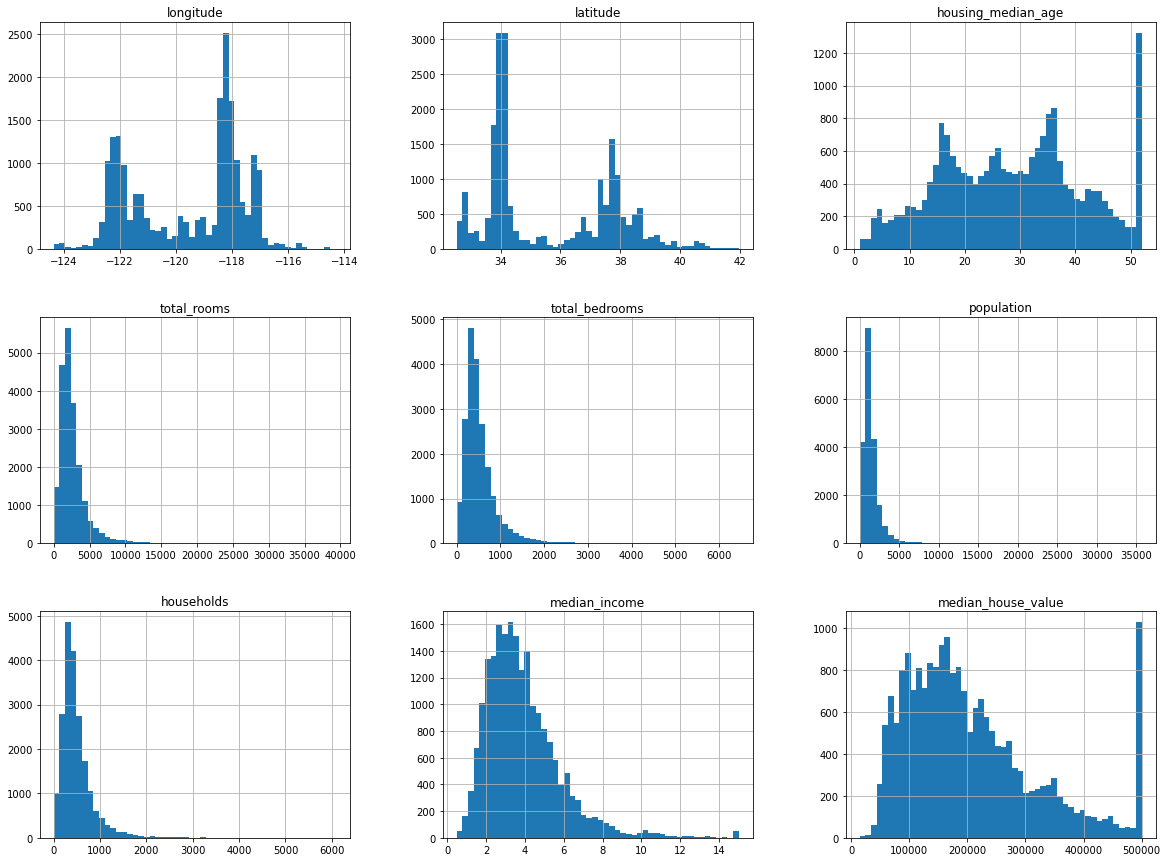

In [10]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

1. `median_income` seems to have some sort of pre-processing - data is expressed in tens of thousands;
2. `housing median_age` and `median_house_value` are capped (i.e. they have a stritct max value). This could be a problem because your model would eventually understand that that is the maximum value allowed for the price of a house.

Ways to deal with this problem would be: a) use the raw values without capping; b)remove districts that have such capped values. <br>


3. Many of the features have different scales and that might be a problem;
4. The distribution of some of the features are *tail-heavy*. Some ML models actually prefer more bell-shaped distributions. Data transformations can solve that to some extent;


## Splitting the data
*** 
When working with sufficiently large datatets, it is always a good option to work with three fragments of your dataset:
1. Train - larger subset of your data (often 80 or 75%). Used to trai (duh) your models;
2. Validation - small fragment of the data (depends on the actual amount of data you have), in this case we could use 10%. This fragment is used as a dataset to evaluate the trained models in the process of tuning;
3. Test - fragment used to test the final models. This has to be treated as new and unseen data at all times. If possible, avoid using it to do any kind of exploration to avoid the effect of *snooping*. In this case, we could use 10% of the data we currently have.

Usually the strategies of training, validation and testing work like so:
1. Train model, evaluate fiting and overfiting.
2. Evaluate the trained model using a subset of that training data (validation subset);
3. Optimize the paramters of the best models, with the intent to get the better performance in the validation subsets;
4. Finally evaluate the best model (now trained using the train+validation datasets) by predicting values of the test subset

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

One of the standard ways to split data is using the `train_test_split` function from SickitLearn. <br>
The code below will generate the train and test datasets, using the proportion of 80% to 20%

In [12]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

One problem that we have is that our data might not contain an even distribution of `median_icome`. Possibly we have more districts with lower income and less districts with bigger incomes. This can lead to problems when we split the data randomly. We might end up with **proportions that are not representative** of `median_icome` in the two subsets.
***
Let's take a look to the distribution of `median_icome` in the dataest by creating some categories

Text(0.5, -0.3, 'Distribution of median_income classes in our dataset')

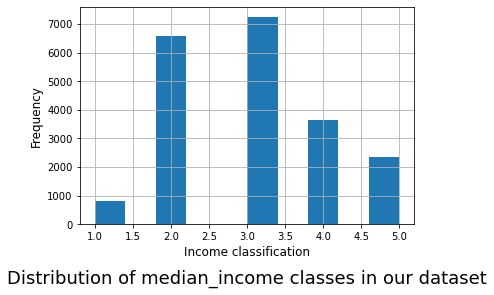

In [13]:
housing['income_cat'] = pd.cut(housing['median_income'], 
                              bins=[0., 1.5, 3.0, 4.5, 6, np.inf],
                              labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist()
plt.xlabel("Income classification", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title('Distribution of median_income classes in our dataset', fontsize=18,
         y=-0.3)

<font color='blue'> >> </font> As we can now see, we have larger frequencies of districts that have "average" median_income values. **Ideally**, we want to perform a data split that maintains that same proportional distribution.

### Separating the data according to income categories 
***
One interesting alternative to perform an accurate split in our data would be by using the SratifiedShuffleSplit method from SickitLearn. This randomly select indexes on the dataset, considering the stratification of a desirable variable (in this cases `income_cat`).

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

In [15]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Now we can see the proportion of each class inside the test data set

In [16]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [17]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [18]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


Looking at the split methods, we note how the error using the stratified method is much lower than that using the random approach

Removing the `income_cat` after we already used it

In [17]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

#### Visualize some of the data

Creating a copy of the training set so I can perform explorations without changing anything important

In [18]:
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

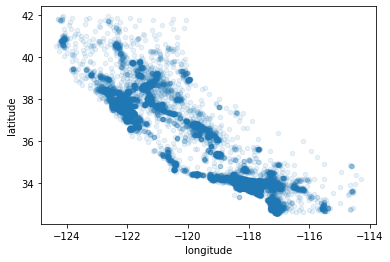

In [19]:
housing.plot(kind='scatter', x='longitude', y='latitude', 
             alpha=0.1)

Looking at house prices

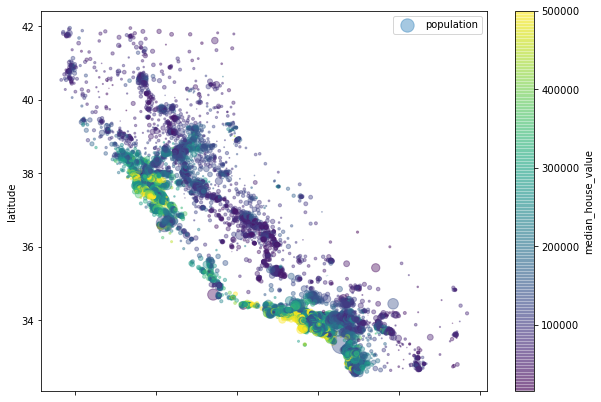

In [24]:
housing.plot(kind='scatter', x='longitude', y='latitude',
             alpha=0.4, s=housing['population']/100,
             label='population', figsize=(10,7), 
             c='median_house_value', cmap=plt.get_cmap('viridis'),
             colorbar=True,)
plt.legend();

In the figure above we can see how the `median_house_value` increases in areas closer to the ocean. At the same time, these areas seem to accumulate more population.

#### Looking into the correlation of variables with the `median_house_value`

In [21]:
corr_matrix = housing.corr()

In [22]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Apparently, the most relevant features are `median_income`, followed by `total_rooms` and then `housing_median_age`. <br>
**Important**: looking only at the correlation values might lead to mistakes, once you can only detect linear relations with these methods. A good practice would be to plot a scatterplot for variables of especial interest.

Lets take a loot into a scatter matrix of relevant variables

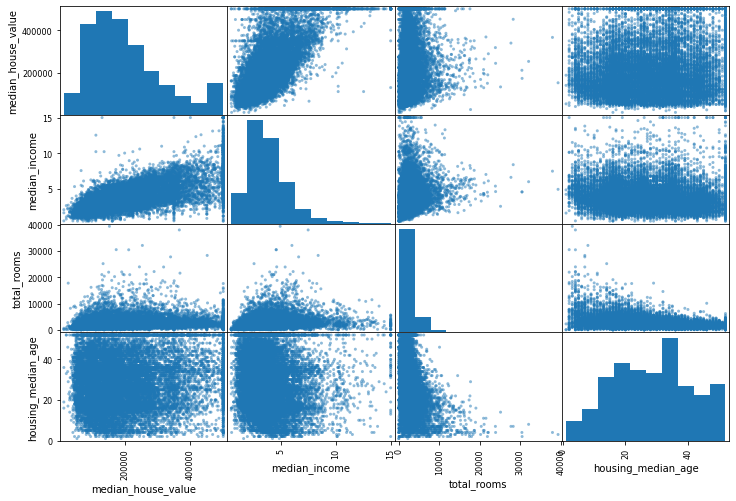

In [23]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms',
             'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8));

We note how the strongest correlation is between `median_house_value` and `median_income`

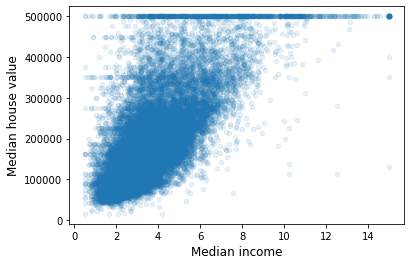

In [27]:
housing.plot(kind='scatter', x='median_income', y='median_house_value',
             alpha=0.1)
plt.ylabel("Median house value", fontsize=12)
plt.xlabel("Median income", fontsize=12);

Consdiering the distribution seen in this scatterplot, we have:
1. Strong positive correlation;
2. Clear straight line representing the cutoff of 500,000;
3. Other straight lines in 350k, 450k and maybe at 280k.

We might opt to remove those districts from the dataset, once the behavior does not look "normal".

### Creating features
***
This is also called feature engineering and might be one valuable asset when trying to train models. For this project, we could think that variables that told us the:
1. Number of rooms per household;
2. Reason of bedrooms per room;
3. Population per household.

...might give us useful information

In [25]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']

In [26]:
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']

In [27]:
housing['population_per_household'] = (housing['population']/housing['households'])

In [28]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

### Preparing the data

In [29]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [30]:
from sklearn.impute import SimpleImputer

In [31]:
imputer = SimpleImputer(strategy='median')

In [32]:
housing_num = housing.drop('ocean_proximity', axis=1)

Fitting the imputer to our data

In [33]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [34]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [35]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Using the "trained" imputer to transform the training set bt replacing missing values with the learned medians

In [36]:
X = imputer.transform(housing_num)

The result is a numpy array containing the features after transformation. If we wish to turn it back into a dataframe, we could:

In [37]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

### Handling text and categorical variables

In [38]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [39]:
from sklearn.preprocessing import OrdinalEncoder

In [40]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [41]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Since the relationship is not ordinal, we must do some one-hot encoding

In [42]:
from sklearn.preprocessing import OneHotEncoder

In [43]:
cat_encoder = OneHotEncoder()

In [44]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [45]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [46]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

If there are many possible classes insided a categorical variable, the one-hot enconding methods can slow down the training process and degrade the performance of the models.

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin

In [48]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

In [49]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no args and kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            berdooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, 
                         berdooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [50]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

In [51]:
housing_extra_values = attr_adder.transform(housing.values)

In [52]:
housing_extra_values

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

#### Feature Scaling

### Transformation Pipelines
***
Pipelines are efficient instructions that can be followed in the same specific order, using the same configurations. In this case, we need to create a pipeline for numerical variables and a separate one for categorical data.

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [54]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [55]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

Categorical variable transformer

In [56]:
from sklearn.compose import ColumnTransformer

In [57]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

In [58]:
housing_prepared = full_pipeline.fit_transform(housing)

## Select and train a Model 

In [59]:
from sklearn.linear_model import LinearRegression

In [60]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [61]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

In [62]:
some_data_prepared = full_pipeline.transform(some_data)

In [63]:
print("Prediction :", lin_reg.predict(some_data_prepared))

Prediction : [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [64]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [65]:
from sklearn.metrics import mean_squared_error

In [66]:
housing_predictions = lin_reg.predict(housing_prepared)

In [67]:
lin_mse = mean_squared_error(housing_labels, housing_predictions)

In [68]:
lin_rmse = np.sqrt(lin_mse)

In [69]:
lin_rmse

68628.19819848923

Underfitting

In [70]:
from sklearn.tree import DecisionTreeRegressor

In [71]:
tree_reg = DecisionTreeRegressor()

In [72]:
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [73]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Overfit

#### Cross validation

In [74]:
from sklearn.model_selection import cross_val_score

In [75]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

In [76]:
tree_rmse_scores = np.sqrt(-scores)

In [77]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

In [78]:
display_scores(tree_rmse_scores)

Scores: [69446.47899522 67901.12065887 69958.3236844  69281.66866845
 71045.64568707 73672.53197891 70566.71745428 70551.17958562
 74535.31474053 68195.12489912]
Mean: 70515.41063524684
Standard deviation: 2039.7407470628682


In [79]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798349


Random forest

In [80]:
from sklearn.ensemble import RandomForestRegressor

In [81]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

Score on the train dataset

In [82]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18737.529572984262

Scores using a validation dataset

In [83]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49487.58731507 47587.60847495 50102.20050085 52108.07896975
 49496.50818608 53609.57420764 48774.60543167 48308.26093128
 52830.78274579 49948.24460484]
Mean: 50225.34513679134
Standard deviation: 1889.2048505866098


Big difference on the scores. We note how the model is stil overfitting the training data

In [84]:
import joblib

In [85]:
joblib.dump(forest_reg, "forest_reg.pkl")

['forest_reg.pkl']

In [86]:
forest_reg_loaded = joblib.load('forest_reg.pkl')

#### TO DO - test some other models. SVM and neural network

#### Hyperparameters
***
Using Grid search

In [90]:
from sklearn.model_selection import GridSearchCV

In [92]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

In [93]:
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

In [94]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [96]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

The best parameters are the maximum values we passed. Let's try with bigger values

In [99]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

Looking at the cv scores

In [103]:
cvres = grid_search.cv_results_

In [107]:
pd.DataFrame.from_dict(cvres).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.045419,0.003441,0.002551,0.000081,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.849569e+09,-3.993423e+09,...,-4.052980e+09,1.876745e+08,18,-1.126255e+09,-9.834478e+08,-1.045946e+09,-1.150728e+09,-1.180500e+09,-1.097375e+09,7.240798e+07
1,0.142773,0.002329,0.007133,0.000214,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.034535e+09,-3.226607e+09,...,-3.095991e+09,1.652178e+08,11,-5.896550e+08,-5.860291e+08,-5.720189e+08,-5.838670e+08,-5.859681e+08,-5.835076e+08,6.038577e+06
2,0.428604,0.006196,0.019842,0.000521,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.588571e+09,-2.916072e+09,...,-2.801153e+09,1.751305e+08,9,-4.447119e+08,-4.224959e+08,-4.292127e+08,-4.454415e+08,-4.291888e+08,-4.342102e+08,9.206969e+06


In [102]:
for mean_score, params in zip(cvres["mean_test_score"], cvres['params']):
    print(np.sqrt(-mean_score), params)

63663.019707149644 {'max_features': 2, 'n_estimators': 3}
55641.62934172382 {'max_features': 2, 'n_estimators': 10}
52925.924625765525 {'max_features': 2, 'n_estimators': 30}
60683.867198037064 {'max_features': 4, 'n_estimators': 3}
52838.25058260181 {'max_features': 4, 'n_estimators': 10}
50416.712948210734 {'max_features': 4, 'n_estimators': 30}
58565.71443152459 {'max_features': 6, 'n_estimators': 3}
52375.20727552176 {'max_features': 6, 'n_estimators': 10}
49994.881828074336 {'max_features': 6, 'n_estimators': 30}
58242.47797936378 {'max_features': 8, 'n_estimators': 3}
52072.346634325506 {'max_features': 8, 'n_estimators': 10}
50077.01166680973 {'max_features': 8, 'n_estimators': 30}
61069.419635586746 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54460.95201552627 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59278.08840498508 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52641.98268903034 {'bootstrap': False, 'max_features': 3, 'n_estimato

#### Randomized search

#### Ensemble methods

#### Analyze the best models and their errors

In [109]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.40143558e-02, 6.63618261e-02, 4.28477104e-02, 1.73301933e-02,
       1.62899035e-02, 1.65480662e-02, 1.62212292e-02, 3.35772014e-01,
       5.77932998e-02, 1.10388977e-01, 8.66404076e-02, 1.11724135e-02,
       1.42487394e-01, 6.72003347e-05, 2.14752648e-03, 3.91748155e-03])

In [115]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.33577201439589505, 'median_income'),
 (0.14248739446318207, 'INLAND'),
 (0.11038897742224177, 'pop_per_hhold'),
 (0.0866404076110398, 'bedrooms_per_room'),
 (0.07401435575614236, 'longitude'),
 (0.06636182605181679, 'latitude'),
 (0.057793299776829676, 'rooms_per_hhold'),
 (0.04284771040802866, 'housing_median_age'),
 (0.017330193345408487, 'total_rooms'),
 (0.016548066212901162, 'population'),
 (0.01628990348848628, 'total_bedrooms'),
 (0.016221229196136402, 'households'),
 (0.011172413507095753, '<1H OCEAN'),
 (0.003917481553917616, 'NEAR OCEAN'),
 (0.0021475264761585946, 'NEAR BAY'),
 (6.720033471947217e-05, 'ISLAND')]

Having this information about feature importance, we could try to drop some variables.. For instance, it seems that only one category of the `ocean_proximity` variable has relevant impact on the model. 

## Evaluating the models on the test set

In [116]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

In [118]:
X_test_prepared = full_pipeline.transform(X_test)

In [123]:
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48112.82890934038

In [124]:
from scipy import stats

In [126]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46159.77817305, 49989.63382876])